In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,55963,None,None,85821.411613
2020-06-13,55964,None,None,79711.201553
2020-06-14,55965,None,None,74044.683009
2020-06-15,55966,None,None,68706.157319
2020-06-16,55967,None,None,63948.634459
...,...,...,...,...
2021-05-07,56292,None,None,15174.522138
2021-05-08,56293,None,None,15620.391981
2021-05-09,56294,None,None,16196.381898


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-11_2021-05-12-16-24.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-10_2021-05-10-16-34.pickle


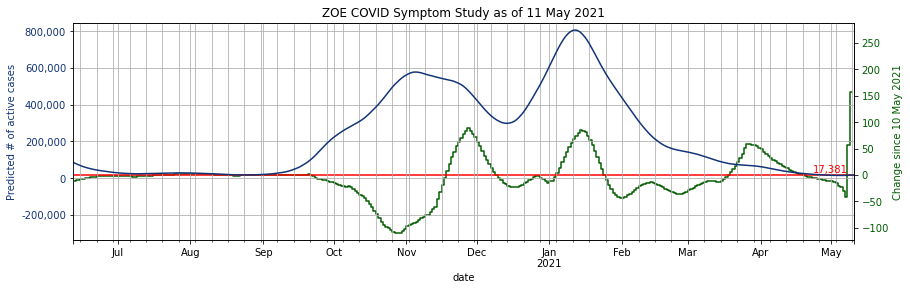

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

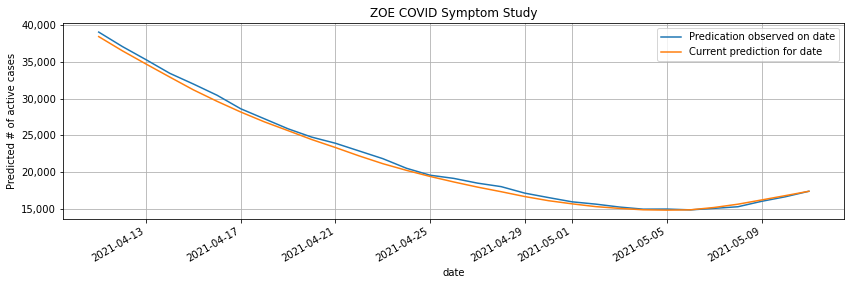

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-05-11_2021-05-12-16-24.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
297,Falkirk,S12000014,0.413784
144,Melton,E07000133,0.349479
240,Wakefield,E08000036,0.279850
280,Doncaster,E08000017,0.258712
324,East Dunbartonshire,S12000045,0.183683
94,Amber Valley,E07000032,0.170567
169,Chorley,E07000118,0.148141
236,Rotherham,E08000018,0.146529
105,Erewash,E07000036,0.134557
204,Selby,E07000169,0.118296
